# Monet paintings GAN transformer

#### The idea for this project (taken from kaggle contests) was to utilize photos taken in 256x256 RGB format and turn them into *Monet-styled* paintings.
#### We will be utilizing a simple GAN in order to take on this challenge!

## Basic imports
#### The idea behind these imports was to try and learn how to use torch convolutional networks whilst making two separate networks to tackle this problem (the generator and the discriminator)

In [1]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import torchvision
import shutil
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

## Dataset constructor

#### More specs on how this constructor works are included below but in a nutshell it will just take in the data in a folder and allow it to be used by the Dataloader in torch.utils

In [2]:
'''
    Basic dataset class, will be used to manipulate the monet dataset 
    
    __init__ args:          folder_path       :       path to folder with dataset images
                            transform         :       transform module from torchvision for data augmentation
                            __len__           :       number of images in dataset
                            __get_item__      :       returns image at index idx tranformed
                            __get_crude_item_ :       returns image at index idx 
                            
                
'''


class PaintingsDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
    
    def __get_crude_item__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        return image
        

## Device adptation, hyperparameters used in training/creating both networks and data augmentation

#### Basically, we will be using <code>torch.cuda.is_available()</code> to check if cuda is available and change model to cuda based on the result
#### Additionally, the hyperparameters and filters in data augmentation (in order to reduce overfitting) were fine-tuned during training and also searched from other public kaggle notebooks for reference (more on that later, in References)

In [3]:
# Device and tensors configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

# Hyperparameters
batch_size = 6
lr = 0.0001
beta1 = 0.56
beta2 = 0.992
n_epoches = 96
display_epoch = 16

"""
Tranform module:

only applying GaussianBlur to dataset, more transformations seemed like a over-kill

"""
transform = transforms.Compose([
    transforms.Resize((256, 256)),

    # Data augmentation 
    #transforms.ElasticTransform(alpha=150.0),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3.)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.15, 0.15, 0.15], std=[0.5, 0.5, 0.5])
])

# Initialize datasets
monet_dataset = PaintingsDataset('/kaggle/input/gan-getting-started/monet_jpg', transform)
photo_dataset = PaintingsDataset('/kaggle/input/gan-getting-started/photo_jpg', transform)


# Initialize data loaders
monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)

## Auxiliary function to display images before and after data augmentation 

In [4]:
"""
Show a random image n from dataset with it's original format and transformed format

args:
        n : example image index
        dataset : dataset of interest

returns:
        plot's with original and transformed image side-by-side
"""

def show_images(n, dataset):
    ex_im_transf = dataset.__getitem__(n)
    ex_im_crude  = dataset.__get_crude_item__(n)

    im_transf = np.squeeze(ex_im_transf) 
    im_crude = np.squeeze(ex_im_crude)

    f, axarr = plt.subplots(1,2)

    for i in range(2):
        axarr[i].axes.get_xaxis().set_visible(False)
        axarr[i].axes.get_yaxis().set_visible(False)

    axarr[1].imshow(im_transf.permute(1, 2, 0))
    axarr[0].imshow(im_crude)
    axarr[1].set_title("Transformed image")
    axarr[0].set_title("Original image")
    plt.show()

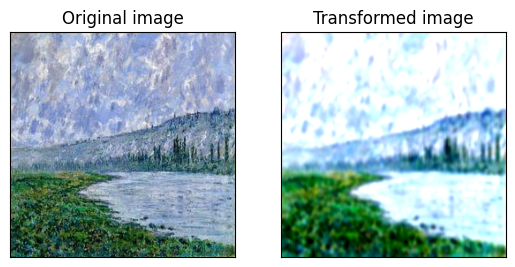

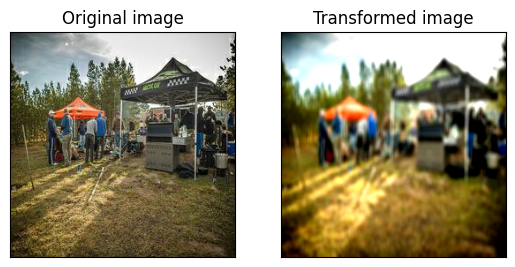

In [5]:
# Visualize data augmentation in both datasets
randn = random.randint(1,298)
show_images(n=randn, dataset=monet_dataset)
show_images(n=randn, dataset=photo_dataset)


## Models used for the generator and discriminator

#### One of the most important parts of the notebook, by far.
#### The idea behind these models was (among other aspects) to to try to make the generator more complex than the discriminator, otherwise the discriminator almost always outpaces the generator and the losses in the generator estabilize way too soon.
#### This model and its training was inspired by <a href=" https://www.kaggle.com/code/adikaboost/cyclegan-resnet-pytorch/notebook"> this notebook </a> and <a href=" https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html"> this torch tutorial</a>

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
    
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            # using ReLU instead of LeakyReLU for faster processing, data is relatively clean and has few outliers.
            nn.ReLU(inplace=True),
        
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            # IstanceNorm because we are using few n in batch
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),   
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),   
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

            
        )

    def forward(self, x):
        return self.model(x)
    

class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.InstanceNorm2d(256)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(
            
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 2 * 3 + 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
            
        )

        self.downsample_blocks = nn.Sequential(
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
            
        )

        self.residual_blocks = nn.Sequential(*[ResidualBlock() for _ in range(num_residual_blocks)])

        self.upsample_blocks = nn.Sequential(
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),   
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
            
        )

        self.output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 2 * 3 + 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)

## Instantiating generator and discriminator object and declaring loss functions and optimezers used
#### Mean Squared Error (MSE) and L1 loss were used as they proved to be more effective and hastly converged toward a local minimun when compared with other loss functions such as Huber loss
#### Adam optimizer was chosen for the same reason


In [7]:
G = Generator()
D = Discriminator()

models = [G, D]
for model in models:
    if torch.cuda.is_available():
        model.cuda()
        
gan_loss = nn.MSELoss().cuda()
cycle_loss = nn.L1Loss().cuda()
identity_loss = nn.L1Loss().cuda()

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

## Auxiliary function to display artificial monet images before and after generator training
#### This function proved very effective at demonstrating the progress of the generator with traning.

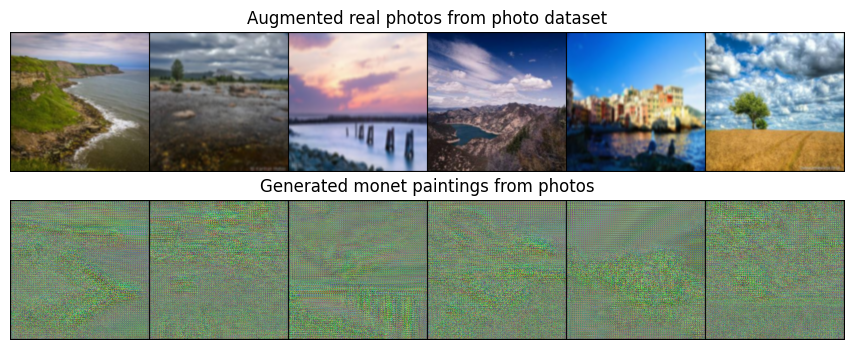

In [8]:
"""
Sample images from batch size n with current generator model parameters

args:
        images with format (n x 3 x size(image) x size(image))

returns:
        plot's with original and transformed image side-by-side
"""

def sample_images(real_X):    
    # turn off some learning parameters in order to evaluate model:
    G.eval()
    
    # transform to tensor and plot images
    real_pic = real_X.type(Tensor)
    artificial_pic = G(real_X).detach()

    ncols = real_X.size(0)
    real_pic_grid = make_grid(real_pic, nrow=ncols, normalize=True)
    artificial_pic_grid = make_grid(artificial_pic, nrow=ncols, normalize=True)

    fig, axs = plt.subplots(2, 1, figsize=(20, 4))  

    axs[0].imshow(real_pic_grid.permute(1, 2, 0).cpu())
    axs[0].set_title("Augmented real photos from photo dataset")
    axs[0].axis('off')

    axs[1].imshow(artificial_pic_grid.permute(1, 2, 0).cpu())
    axs[1].set_title("Generated monet paintings from photos")
    axs[1].axis('off')


    plt.show()

real_X = next(iter(photo_loader))
real_Y = next(iter(photo_loader))
sample_images(real_X.to(device))

## Network training
#### Another very significant part of the project!
#### In a nutshell, the generator losses were divided in 2 parts: <code>identity loss</code> and <code>gan loss</code> and both had to impact the backward propagation in different proportions. Therefore both were added and used in the optimizer.
#### The dicriminator loss was also divided in two parts:  <code>real painting missclassification loss</code> and  <code>artificial painting missclassification loss</code>. Basically the loss when misclassifying a fake painting as a true painting and misclassifying a true painting as a fake paiting.

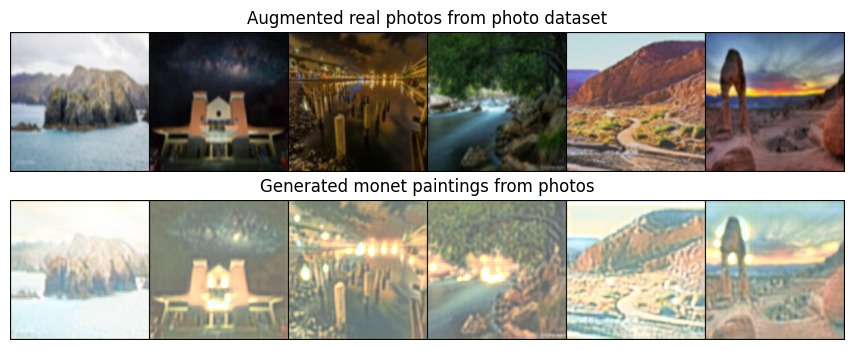

Epoch 16 | 96
Generator loss: 1.8132010698318481 =  1.0778182744979858 (5 * identity loss) + 0.7353827953338623 (GAN loss)
Discriminator loss: 0.10247379541397095 = 0.08505465090274811 (real monet loss/2)  + 0.03483828902244568 (generated monet loss/2)


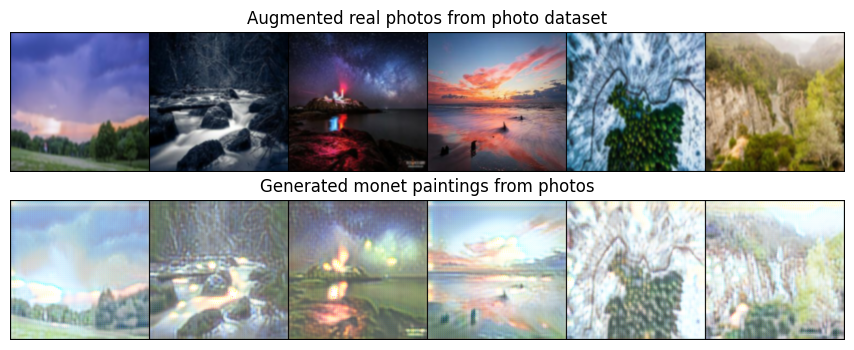

Epoch 32 | 96
Generator loss: 1.828721046447754 =  0.8959589898586273 (5 * identity loss) + 0.932762086391449 (GAN loss)
Discriminator loss: 0.009455755352973938 = 0.002401747740805149 (real monet loss/2)  + 0.014108016155660152 (generated monet loss/2)


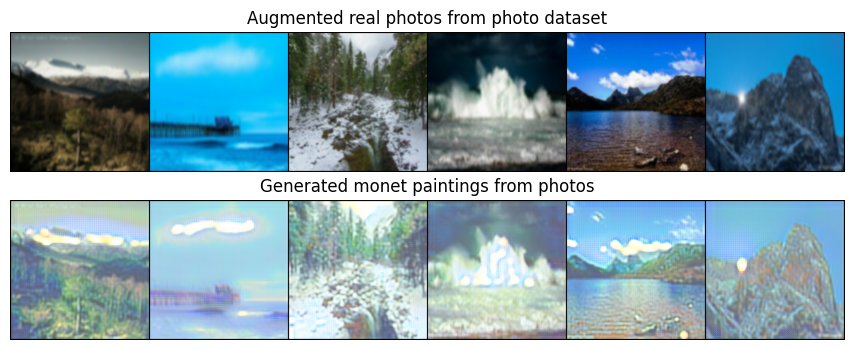

Epoch 48 | 96
Generator loss: 1.9062552452087402 =  0.9800773113965988 (5 * identity loss) + 0.9261778593063354 (GAN loss)
Discriminator loss: 0.0057221632450819016 = 0.001639731926843524 (real monet loss/2)  + 0.008164862170815468 (generated monet loss/2)


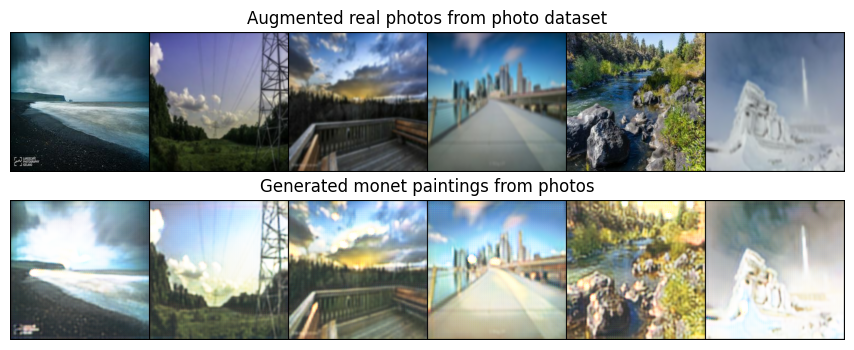

Epoch 64 | 96
Generator loss: 1.7278003692626953 =  0.7144808024168015 (5 * identity loss) + 1.013319492340088 (GAN loss)
Discriminator loss: 0.002393532544374466 = 0.0013449590187519789 (real monet loss/2)  + 0.002097147284075618 (generated monet loss/2)


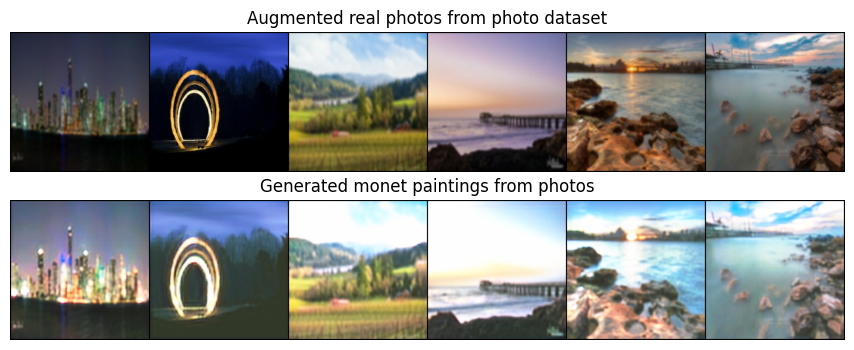

Epoch 80 | 96
Generator loss: 1.620293378829956 =  0.6139297038316727 (5 * identity loss) + 1.0063637495040894 (GAN loss)
Discriminator loss: 0.0005346696707420051 = 0.0003078793524764478 (real monet loss/2)  + 0.0004535806365311146 (generated monet loss/2)


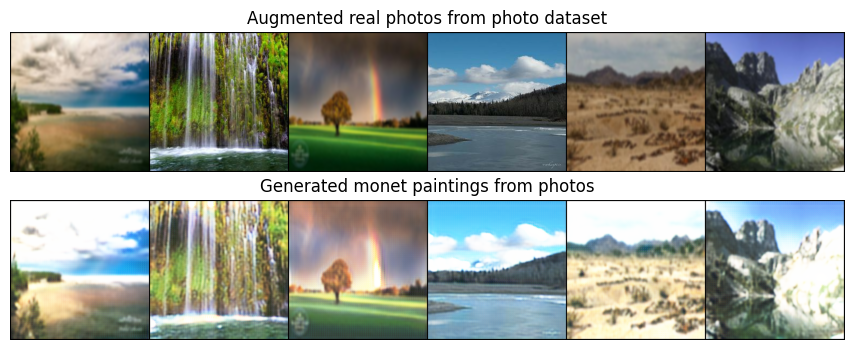

Epoch 96 | 96
Generator loss: 1.6416304111480713 =  0.6462829560041428 (5 * identity loss) + 0.9953473806381226 (GAN loss)
Discriminator loss: 0.0008823024109005928 = 0.0005872423644177616 (real monet loss/2)  + 0.0005901201511733234 (generated monet loss/2)


In [9]:
for epoch in range(n_epoches):
    for i, (real_photo, real_monet) in enumerate(zip(photo_loader, monet_loader)):

        real_photo = real_photo.type(Tensor)
        real_monet = real_monet.type(Tensor)
        
        out_shape = [real_photo.size(0), 1, real_photo.size(2) , real_photo.size(3)]
        
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        
        # training generator
        G.train()
        optimizer_G.zero_grad()
        artificial_monet = G(real_photo)

        
        # identity loss
        loss_identity = identity_loss(artificial_monet, real_photo)
        
        # gan loss
        loss_GAN = gan_loss(D(artificial_monet), valid) 
        
        # total gan loss
        loss_G = 5.0 * loss_identity + loss_GAN 
        
        loss_G.backward()
        optimizer_G.step()
        
        # training discriminator 
        optimizer_D.zero_grad()
        
        # real painting misclassification loss
        loss_real = gan_loss(D(real_monet), valid)
        
        # artificial painting misclassification loss
        loss_fake = gan_loss(D(artificial_monet.detach()), fake)
        loss_D = (loss_real + loss_fake) / 2
        
        loss_D.backward()
        optimizer_D.step()
    
    # sample results every n=display_epoch
    
    if (epoch + 1) % display_epoch == 0:
        test_real_photo, test_real_monet = next(iter(zip(photo_loader, monet_loader)))
        sample_images(test_real_photo.type(Tensor))

        print(f'Epoch {epoch + 1} | {n_epoches}')
        print(f'Generator loss: {loss_G.item()} =  {5 * loss_identity.item()} (5 * identity loss) + {loss_GAN.item()} (GAN loss)')
        print(f'Discriminator loss: {loss_D.item()} = {loss_real.item()/2} (real monet loss/2)  + {loss_fake.item()} (generated monet loss/2)')

## Create directory to save new images
#### Pretty straightfoward, just save the images batch by batch

In [10]:
# create path to save created monet paintings
transformed_save_dir = '../images'
if not os.path.exists(transformed_save_dir):
    os.makedirs(transformed_save_dir)
    
# freeze some network params to generate imgs
G.eval()


for i, real_photos in enumerate(photo_loader):
    real_photos = real_photos.to(device)
    with torch.no_grad():
        monet_style_imgs = G(real_photos)

    # Save each transformed image
    for j, img in enumerate(monet_style_imgs):
        save_path = os.path.join(transformed_save_dir, f'monet_painting_{i * batch_size + j}.png')
        torchvision.utils.save_image(img, save_path)

print(f"Transformed images are saved in {transformed_save_dir}")

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

Transformed images are saved in ../images


'/kaggle/working/images.zip'

## Results

#### My project recieved a score of **87.00933** and had a run time of **1772.3s** in a **GPU P100**
#### <a href="https://www.kaggle.com/code/enzou3/gans-in-monets-paintings?scriptVersionId=158747815">Here</a> is the link to the submission
#### All the artificial paintings created can be found in <code>"/monet-paintings/monet-output-images"</code> so you can see for yourself what the networks were capable of!

## References
#### Most of my work was inspired by two kaggle notebooks that tackled this problem before me and the Pytorch DCGAN tutorial: <a href=" https://www.kaggle.com/code/adikaboost/cyclegan-resnet-pytorch/notebook"> notebook 1</a>, <a href=" https://www.kaggle.com/code/adikaboost/cyclegan-resnet-pytorch/notebook"> notebook 2</a>, <a href="https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html">DCGAN tutorial</a>.
#### The monet and photos dataset provided belongs to <a href="https://www.kaggle.com">Kaggle</a>.
#### Thanks for checking out my project! :)